# Определение тональности комментариев

## Описание исследования
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

## Цель исследования
Построить модель для классификации комментариев на позитивные и негативные.

## Задачи исследования
Построить модель со значением метрики качества $F1$ не меньше 0.75.

## Исходные данные
Набор данных с разметкой о токсичности правок.

## План исследования

***[Часть 1. Загрузка данных](#dataloading)***

***[Часть 2. Предобработка данных](#datapreprocessing)***

***[Часть 3. Обучение моделей:](#ml)***
* [1. Языковые представления при помощи BERT](#ml)
* * [1.1. Подготовка данных](#prep)
  * [1.2. Обучение модели](#learn)
* [2. TF-IDF](#tf-idf)

***[Часть 4. Вывод](#summary)***

<a id='dataloading'></a>
## Загрузка данных
Импортирование нужных библиотек

In [25]:
!pip install torch -q
!pip install lightgbm -q
!pip install transformers -q
!pip install tqdm -q
!pip install nltk -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers
from tqdm import notebook
import warnings
warnings.simplefilter("ignore")

import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', titlesize=16, titlepad=10)

Загрузка датасетa

In [4]:
try:
    toxic_comments = pd.read_csv('~/datasets/toxic_comments.csv', index_col=0)
except:
    toxic_comments = pd.read_csv('__private_data__', index_col=0)

Выведем первые 5 строк датафрейма

In [8]:
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Данные загрузились и выводятся правильно, приступим к предобработке данных.

<a id='datapreprocessing'></a>
## Предобработка данных
Выведем основную информацию

In [12]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Пропусков нет, тональность определена для каждого комментария в датасете.

Проверим, есть ли дубликаты.

In [15]:
print('Число полных дубликатов:', toxic_comments.duplicated().sum())
print('Число дубликатов комментариев:', toxic_comments['text'].duplicated().sum())

Число полных дубликатов: 0
Число дубликатов комментариев: 0


Дубликатов нет. Проверим, есть ли лишние значения в столбце `toxic`.

In [18]:
print(f'Уникальные значения целевого признака: {list(toxic_comments["toxic"].unique())}')

Уникальные значения целевого признака: [0, 1]


Неожиданных значений нет.

Посмотрим на отношение классов в датафрейме.

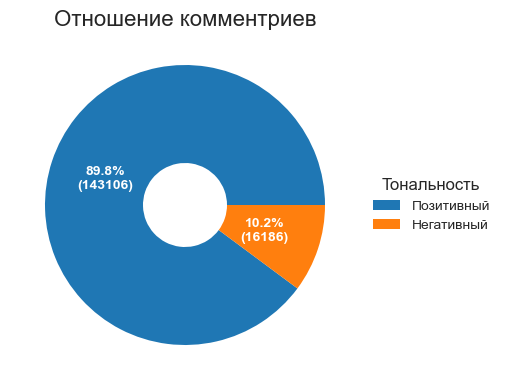

In [21]:
fig, ax = plt.subplots(figsize=(12, 4), subplot_kw=dict(aspect="equal"))

data = toxic_comments['toxic'].value_counts()
tone = ['Позитивный', 'Негативный']

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: f"{pct:.1f}%\n({int(np.round(pct/100.*np.sum(data))):d})",
                                  textprops=dict(color="w"), wedgeprops=dict(width=0.7))

ax.legend(wedges, tone,
          title="Тональность",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10,
          title_fontsize=12)

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Отношение комментриев", pad=0);

Заметен дисбаланс классов, при делении данных на выборки это стоит учесть.

Можем приступить к обучению моделей.

<a id='ml'></a>
## Обучение моделей
### Языковые представления при помощи BERT

<a id='prep'></a>
#### Подготовка данных

Для классификации построим векторные представления комментариев при помощи BERT.

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
tokenized = toxic_comments['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

In [11]:
max_len = tokenized.apply(lambda x: len(x)).max()
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = transformers.BertModel.from_pretrained('bert-base-uncased')
model.to(device);

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.tensor(padded[batch_size*i:batch_size*(i+1)], device=device)
    attention_mask_batch = torch.tensor(attention_mask[batch_size*i:batch_size*(i+1)], device=device)
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

features = np.concatenate(embeddings)

  0%|          | 0/1592 [00:00<?, ?it/s]

Сохраним полученные векторные представления для более удобной работы с ними в будущем.

In [16]:
np.save('toxic_embeddings.npy', features)

In [27]:
features = np.load('toxic_embeddings.npy') # загрузка векторных представлений

<a id='learn'></a>
#### Обучение модели
Разобьём данные на тренировочную, валидационную и тестовую выборки

In [31]:
target = toxic_comments['toxic'].iloc[:features.shape[0]]
X, X_test, y, y_test = train_test_split(features, target, stratify=target, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.10, random_state=42)


print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape, end='\n\n')
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape, end='\n\n')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (128952, 768)
y_train shape: (128952,)

X_val shape: (14328, 768)
y_val shape: (14328,)

X_test shape: (15920, 768)
y_test shape: (15920,)


Обучим модель бинарной классификации.

In [34]:
log_reg = SGDClassifier(random_state=42, penalty='l2', loss='log_loss')
log_reg.fit(X_train, y_train)
print(f'F1: {f1_score(y_test, log_reg.predict(X_test))}')

F1: 0.7026439695762405


Попробуем найти порог классификации, при котором $F1$ больше.

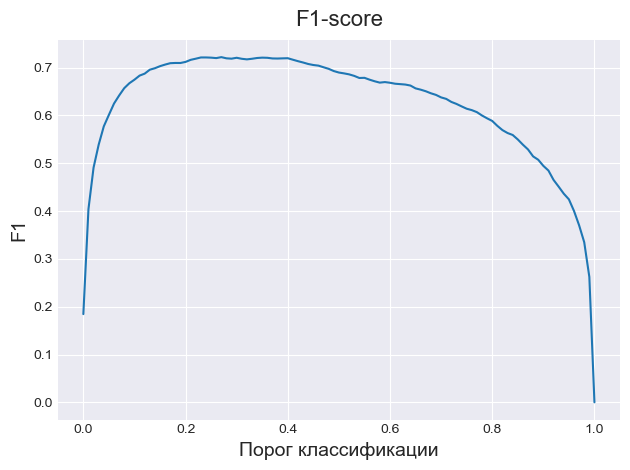

In [36]:
thresholds = np.linspace(0, 1, 101)
f1_scores = list()
for threshold in thresholds:
    f1_scores.append(f1_score(y_val, [1 if proba > threshold else 0 for proba in \
                                       log_reg.predict_proba(X_val)[:, 1]]))
plt.plot(thresholds, f1_scores)
plt.title('F1-score')
plt.xlabel('Порог классификации', fontsize=14)
plt.ylabel('F1', fontsize=14);

In [37]:
print(f'F1: {f1_score(y_test, [1 if i > 0.3 else 0 for i in log_reg.predict_proba(X_test)[:, 1]]):.3%}')

F1: 73.385%


Метрика *F1* не достигает требуемых значений *(более 0.75)*. Попробуем улучшить показатели при помощи *TF-IDF*.

<a id='tf-idf'></a>
### TF-IDF

Удалим лишние символы и лемматизируем комментарии.

In [126]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(text):
    """Получение списка POS-тегов для всего текста"""
    tags = [word[1][0].upper() for word in nltk.pos_tag(text)]
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return [tag_dict.get(tag, wordnet.NOUN) for tag in tags]

lemmatizer = WordNetLemmatizer()
def get_lemma(text):
    text = ' '.join(re.sub(r"[^a-zA-Z]", ' ', text).split()).lower()
    words = nltk.word_tokenize(text)
    positions = get_wordnet_pos(words)
    return ' '.join([lemmatizer.lemmatize(words[i], pos=positions[i]) for i in range(len(nltk.word_tokenize(text)))])

features_tf_idf = toxic_comments['text'].apply(lambda x: get_lemma(x))
features_tf_idf

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/valera_gorbachev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/valera_gorbachev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/valera_gorbachev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159446    and for the second time of ask when your view ...
159447    you should be ashamed of yourself that be a ho...
159448    spitzer umm theres no actual article for prost...
159449    and it look like it be actually you who put on...
159450    and i really don t think you understand i come...
Name: text, Length: 159292, dtype: object

Разделим данные на тренировочную, валидационную и тестовую выборки.

In [128]:
X_tf_idf, X_test_tf_idf, y_tf_idf, y_test_tf_idf = train_test_split(features_tf_idf, toxic_comments['toxic'], stratify=toxic_comments['toxic'], test_size=0.10, random_state=42)

X_train_tf_idf, X_val_tf_idf, y_train_tf_idf, y_val_tf_idf = train_test_split(X_tf_idf, y_tf_idf, stratify=y_tf_idf, test_size=0.10, random_state=42)

print('X_train shape:', X_train_tf_idf.shape)
print('y_train shape:', y_train_tf_idf.shape, end='\n\n')
print('X_val shape:', X_val_tf_idf.shape)
print('y_val shape:', y_val_tf_idf.shape, end='\n\n')
print('X_test shape:', X_test_tf_idf.shape)
print('y_test shape:', y_test_tf_idf.shape)

X_train shape: (129025,)
y_train shape: (129025,)

X_val shape: (14337,)
y_val shape: (14337,)

X_test shape: (15930,)
y_test shape: (15930,)


Cоздадим признаки для обучения

In [130]:
count_tf_idf = TfidfVectorizer(stop_words='english')
tf_idf_train = count_tf_idf.fit_transform(X_train_tf_idf)
tf_idf_val = count_tf_idf.transform(X_val_tf_idf)
tf_idf_test = count_tf_idf.transform(X_test_tf_idf)

Обучим модель логистической регрессии и сделаем предсказание на тестовой выборке.

In [134]:
log_reg_tf_idf = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_tf_idf.fit(tf_idf_train, y_train_tf_idf)
print(f'F1: {f1_score(y_test_tf_idf, log_reg_tf_idf.predict(tf_idf_test))}')

F1: 0.7782837127845884


Требуемое значение $F1$ уже достигнуто. Изменим порог классификации для увеличения метрики.

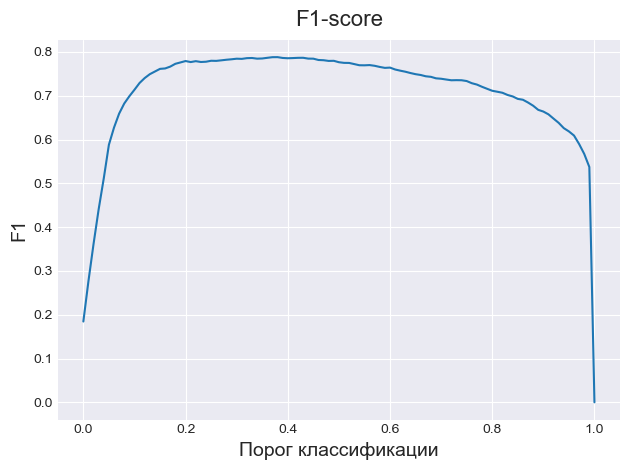

In [137]:
thresholds = np.linspace(0, 1, 101)
f1_scores = list()
for threshold in thresholds:
    f1_scores.append(f1_score(y_val_tf_idf, [1 if proba > threshold else 0 for proba in \
                                       log_reg_tf_idf.predict_proba(tf_idf_val)[:, 1]]))
plt.plot(thresholds, f1_scores)
plt.title('F1-score')
plt.xlabel('Порог классификации', fontsize=14)
plt.ylabel('F1', fontsize=14);

In [143]:
print(f'F1: {f1_score(y_test_tf_idf, [1 if proba > 0.36 else 0 for proba in log_reg_tf_idf.predict_proba(tf_idf_test)[:, 1]]):.3%}')

F1: 79.538%


На этот раз метрика нас устраивает. При этом обучение этой модели заняло значительно меньше времени, чем основанной на языковых представлениях.

<a id='summary'></a>
## Вывод

В ходе исследования были построены две модели для предсказания токсичности комментариев:

- Первая модель была обучена на эмбеддингах, построенных при помощи *BERT*
- Вторая модель обучилась на *TF-IDF*

Первая модель не смогла достигнуть нужного нам качества ($F1$ не менее 0.75), при этом создание эмбеддингов заняло значительное время.

Вторая же модель удовлетворяет требованиям с $F1$ на тестовой выборке более 0.79. Помимо этого, создание признаков для обучения не потребовало много времени.

Потенциально модель можно упростить ещё больше, например, убрав малозначащие признаки. $F1$ можно увеличить, настроив *TfidfVectorizer* и получив больше признаков, а также используя другие архитектуры моделей, при этом длительность обучения, скорее всего, увеличится.